Source to following code: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
<br>
Second source is: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#a = [0.784343, 0.637263266326]
#a = np.array(a)
#a = np.around(a,1)
#print(a)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [79]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2

import math
import os

In [5]:
tf.random.set_seed(1)

In [6]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/X.pickle","rb")
# Remove binary version
X = pickle.load(pickle_in)

#pickle_in = open(path+"/y_speed_gray.pickle","rb")
# Remove binary version
#y_speed = pickle.load(pickle_in)

pickle_in = open(path+"/y_angle.pickle","rb")
# Remove binary version
y_angle = pickle.load(pickle_in)

pickle_in = open(path+"/image_id.pickle","rb")
# Remove binary version
imageId = pickle.load(pickle_in)

In [7]:
imageId = np.array(imageId)

Standard deviation of the angles

0.15555820377620497

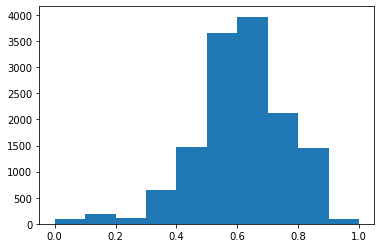

In [8]:
plt.hist(y_angle)
statistics.stdev(y_angle)

Now we can find how many duplicate angles there exist in the y_angles

In [9]:
(unique, counts) = np.unique(y_angle, return_counts=True)

In [10]:
print("Unique angles =",len(unique))
print("The total length of the angle array is",len(y_angle))

Unique angles = 17
The total length of the angle array is 13793


In [11]:
print( np.asarray((unique, counts)).T )

[[0.000e+00 6.000e+01]
 [6.250e-02 2.800e+01]
 [1.250e-01 9.900e+01]
 [1.875e-01 9.800e+01]
 [2.500e-01 1.040e+02]
 [3.125e-01 2.130e+02]
 [3.750e-01 4.280e+02]
 [4.375e-01 1.467e+03]
 [5.000e-01 2.046e+03]
 [5.625e-01 1.609e+03]
 [6.250e-01 1.963e+03]
 [6.875e-01 2.007e+03]
 [7.500e-01 2.123e+03]
 [8.125e-01 1.147e+03]
 [8.750e-01 3.010e+02]
 [9.375e-01 6.500e+01]
 [1.000e+00 3.500e+01]]


In [12]:
print(y_angle)
print(imageId)

[0.5625 0.5625 0.8125 ... 0.6875 0.8125 0.6875]
[ 9030  9027    91 ... 10749 10642 10776]


0.625
2866


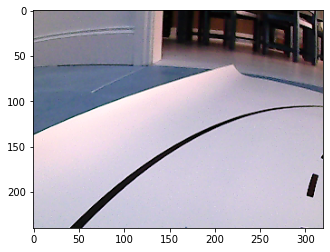

In [13]:
show = 7000
plt.imshow(X[show,:,:,:])
print(y_angle[show])
print(imageId[show])

In [14]:
X.shape[0]
#index = np.where(y_angle == 0.0)
#print(index[0])
#print(imageId[index])

13793

The fact that there are only 17 angles allows us to only use some images

In [15]:
def smallerDatasetCreation(image_array,anlge_array,unique_angle, maximumNumberOfImagesForAnyAngle, id_array):
  index = np.where(anlge_array == unique_angle)
  idOfImages = id_array[index]
  image_array_new = image_array[index,:,:,:]
  image_array_new = image_array_new.reshape(image_array_new.shape[1],image_array_new.shape[2],image_array_new.shape[3],image_array_new.shape[4])
  #print(image_array_new.shape)
  if image_array_new.shape[0] > maximumNumberOfImagesForAnyAngle: # If more than X pictures exist for the specific angle then:
    # Shuffle images
    image_array_new,idOfImages = shuffle(image_array_new,idOfImages)
    image_array_new,idOfImages = shuffle(image_array_new,idOfImages)

    image_array_new = image_array_new[0:maximumNumberOfImagesForAnyAngle,:,:,:]
    idOfImages = id_array[0:maximumNumberOfImagesForAnyAngle]
    #print(image_array_new.shape)
  return(image_array_new, idOfImages)

In [16]:
X_new = []
y_angle_new = []
idImage = []
totalNumberOfImages = 0
maxNumberOfImages = 99

for uniqueAngle in unique:
    X_reduced, id = smallerDatasetCreation(X,y_angle,uniqueAngle,maxNumberOfImages, imageId)
    totalNumberOfImages = totalNumberOfImages + X_reduced.shape[0]

    print(totalNumberOfImages)
    #print(X_reduced.shape[0])
    X_new.extend(X_reduced)
    idImage.extend(id)
    
    # Create also new y_angle array to match the X
    #y_angle_new.extend(np.ones(X_reduced.shape[0]) * uniqueAngle)
    y_angle_new.extend(np.ones(X_reduced.shape[0]) * uniqueAngle)

    #idImage.append()
    #print(uniqueAngle)

60
88
187
285
384
483
582
681
780
879
978
1077
1176
1275
1374
1439
1474


In [17]:
print(len(X_new))
print(len(y_angle_new))
print(len(idImage))

1474
1474
1474


In [18]:
X_new = np.array(X_new)
y_angle_new = np.array(y_angle_new)
idImage = np.array(idImage)
print(X_new.shape)
print(y_angle_new.shape)
print(idImage.shape)

(1474, 240, 320, 3)
(1474,)
(1474,)


0.0
3794


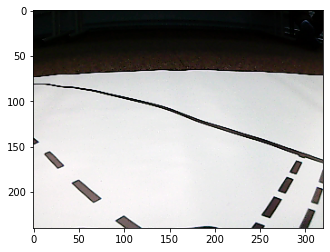

In [19]:
plt.imshow(X_new[25,:,:,:])
print(y_angle_new[25])
print(idImage[25])

Shuffle the two X_new and y_angle arrays. Note that sklearn shuffle allows us to shuffle two arrays as they were together

In [20]:
# Triple shuffling
X_new, y_angle_new,idImage = shuffle(X_new, y_angle_new, idImage)
X_new, y_angle_new,idImage = shuffle(X_new, y_angle_new, idImage)
X_new, y_angle_new,idImage = shuffle(X_new, y_angle_new, idImage)

1.0
13259


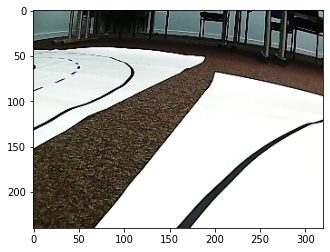

In [21]:
plt.imshow(X_new[21,:,:,:])
print(y_angle_new[21])
print(idImage[21])

Preprocces images to scale, normalize change RGB to YUV and add gaussian noise

In [22]:
def img_preprocess(image):
    height, _, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!

    #image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    #image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    return image

In [23]:
X_final = []
for img_index in range(X_new.shape[0] ):
  X_f = img_preprocess(X_new[img_index,:,:,:])
  X_final.append(X_f)

In [24]:
X_final = np.array(X_final)
#X_final = np.array(X_final, dtype=np.float16)

Create a test dataset to ensure that we do not overfit

In [25]:
X_train, X_test, y_train, y_test = train_test_split( X_final, y_angle_new, test_size=0.1, random_state=42)

In [31]:
# This is to realease some RAM
X_final = []
X_new = []

0.875


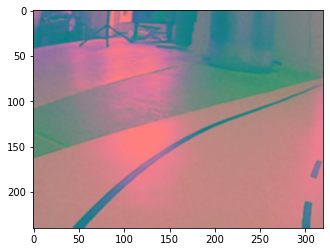

In [38]:
plt.imshow(X_train[22,:,:,:])
print(y_train[22])
#print(idImage[21])

In [29]:
print(X_train.shape)
tf_y_train = tf.reshape(y_train,[ y_train.shape[0] ,1 ]).numpy()
print(y_train.shape)
print(tf_y_train.shape)

(1326, 240, 320, 3)
(1326,)
(1326, 1)


In [66]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Exponential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='elu')) 
    #model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(120, 320, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    #model.add(Dropout(0.1))
    #model.add(Dense(200, activation='elu')) # NOT PART OF NVIDIA
    #model.add(Dense(200, activation='elu'))

    model.add(Dropout(0.1)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    #model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='elu'))
    #model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.05))
    model.add(Dense(10, activation='elu'))
    #model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    #optimizer = Adam(lr=1e-7) # lr is learning rate
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 118, 158, 24)      1824      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 57, 77, 36)        21636     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 27, 37, 48)        43248     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 35, 64)        27712     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 23, 33, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 48576)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48576)            

In [67]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=7, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(X_train, tf_y_train, batch_size=64, epochs=100, validation_split=0.2,callbacks=[monitor])

Epoch 1/100
17/17 [==============================] - 4s 183ms/step - loss: 323.1732 - val_loss: 0.2960
Epoch 2/100
17/17 [==============================] - 3s 160ms/step - loss: 0.4655 - val_loss: 0.1389
Epoch 3/100
17/17 [==============================] - 3s 160ms/step - loss: 0.2280 - val_loss: 0.0698
Epoch 4/100
17/17 [==============================] - 3s 160ms/step - loss: 0.1152 - val_loss: 0.0764
Epoch 5/100
17/17 [==============================] - 3s 159ms/step - loss: 0.0958 - val_loss: 0.0719
Epoch 6/100
17/17 [==============================] - 3s 160ms/step - loss: 0.0775 - val_loss: 0.0703
Epoch 7/100
17/17 [==============================] - 3s 161ms/step - loss: 0.0804 - val_loss: 0.0693
Epoch 8/100
17/17 [==============================] - 3s 159ms/step - loss: 0.0693 - val_loss: 0.0725
Epoch 9/100
17/17 [==============================] - 3s 158ms/step - loss: 0.0903 - val_loss: 0.0746
Epoch 10/100
17/17 [==============================] - 3s 158ms/step - loss: 0.0718 - val_

In [82]:
steering_angle = model.predict(X_test)

In [83]:
gc.collect()

1442

In [84]:
for i in range(y_test.shape[0]):  
  #print([steering_angle[i][0], tf_y_angle[i][0]])
  print([steering_angle[i][0], y_test[i] ])

[0.78031707, 0.8125]
[0.47895348, 0.3125]
[0.72960556, 0.5625]
[0.5136228, 0.4375]
[0.5084447, 0.875]
[0.7293305, 0.375]
[0.2945276, 0.3125]
[0.38099837, 0.5625]
[0.7377465, 0.8125]
[0.24120337, 0.0]
[0.7562259, 0.8125]
[0.30702144, 0.1875]
[0.7147244, 0.9375]
[0.45943755, 0.4375]
[0.76267517, 0.6875]
[0.846779, 0.9375]
[0.3583117, 0.1875]
[0.5842588, 0.8125]
[0.66568655, 0.5625]
[0.5846574, 0.1875]
[0.58824384, 0.4375]
[0.48351544, 0.5]
[0.1764, 0.3125]
[0.76190925, 0.9375]
[0.7125542, 0.6875]
[0.40363425, 0.1875]
[0.45207417, 0.4375]
[0.41191965, 0.25]
[0.29384077, 0.375]
[0.30918312, 0.625]
[0.46085012, 0.5625]
[0.36858982, 0.1875]
[0.5356629, 0.5625]
[0.58881336, 0.5]
[0.51661247, 0.5625]
[0.5759913, 0.4375]
[0.6127725, 0.5625]
[0.5241655, 0.1875]
[0.6663698, 0.8125]
[0.44797707, 0.5625]
[0.7546323, 1.0]
[0.44877928, 0.5]
[0.045462903, 0.1875]
[0.7583536, 0.75]
[0.51858646, 0.125]
[0.5316113, 1.0]
[0.6375448, 0.625]
[0.69337934, 0.625]
[0.36280817, 0.25]
[0.5982133, 0.3125]
[0.5594

Calculate the Mean squared error

In [85]:
mseSum = 0
print(y_test.shape[0])
for i in range(y_test.shape[0]):
  mseSum += (1/y_test.shape[0] ) *  (steering_angle[i][0] - y_test[i])**2
print(mseSum)

148
0.03633230387430994


In [74]:
model.save(os.path.join(path,'Angle_prediction_model.h5'))

In [75]:
del model

In [81]:
model = load_model(path+'/Angle_prediction_model.h5')

Now save the model output

In [ ]:
#import os
# always save model output as soon as model finishes training
#model.save(os.path.join(path,'angle_prediction.h5'))

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(32))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.fit(X, y_speed, batch_size=32, epochs=2, validation_split=0.8)

Run the same model as above for angle prediction but change the loss function since we do not have classification. ALso accuracy is not a term to measure.

In [ ]:
#y_angle

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(64))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='mean_squared_error',
#               optimizer='adam')

# model.fit(X, y_angle, batch_size=32, epochs=2, validation_split=0.95)